In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from decimal import Decimal
import scipy.integrate
import os
from datetime import date

pltpath = 'plots'
if not os.path.exists(pltpath):
    os.mkdir(pltpath)
    print("Created folder " + pltpath)
    
fs = 14
matplotlib.rcParams.update({'font.size': fs})
lw = 2
footnote = 'Albà, ' + str(date.today())
for_report = False
print(footnote)
raw_data = []

# Edit here ########################
# "inline" for normal mode, "notebook" for interactive mode
%matplotlib inline

# raw_data.append( ['.', 'N = 5e4, E = 50 MeV, Q = 1 nC' ] )
raw_data.append( ['example2', 'N = 5e4, E = 50 MeV, Q = 1 nC' ] )

generic_title = str('K = 11.1, $L_u$ = 85 cm, $\lambda_u$ = 8.5 cm')
####################################

# Get parameters from each folder
folders = []
leg = []
rb = []
lT = []
screens = []
nump = []
time_stamps = []
comp_time = []
dt = []
for i, el in enumerate(raw_data):
    folders.append( el[0] )
    leg.append( el[1] )
    # Get undulator begin rb, simulation time, dt, num screens, and longitudinal truncation
    for name in os.listdir(folders[i]):
        if 'slurm' in name:
            fn = str( folders[i] + '/' + name)
    screens_here = []
    for line in open(fn):
        if "undulator is set at the point " in line:
            ind = line.find('point')
            rb.append( float(line[ind + 6:]) )
        if "Longitudinal truncation " in line:
            ind = line.find('=')
            lT.append( float(line[ind + 2:]) )
        if "::: total simulation time" in line:
            ind = line.find('=')
            comp_time.append( float(line[ind + 1:])/60 )
        if "Time step for the field" in line:
            ind = line.find('to')
            dt.append( float(line[ind + 3:]) )
        if "at distance" in line:
            ind = line.find('distance')
            ind2 = line.find('from')
            screens_here.append( float(line[ind + 9:ind2]) )
    screens.append(screens_here)
    # Get time stamps
    if not ( os.path.isdir( str(folders[i] + '/bunch-profile') ) ):
        time_stamps.append([])
        continue
    maxim = 0
    ts = []
    for name in os.listdir( str(folders[i] + '/bunch-profile') ):
        ind1 = name.find('-')
        ind2 = ind1 + 1 + name[ind1+1:].find('-')
        if int(name[ind1 + 2 : ind2]) > maxim:
            maxim = int(name[ind1 + 2 : ind2])
        ind3 = name.find('.txt')
        if not int(name[ ind2 + 1 : ind3 ]) in ts:
            ts.append( int(name[ ind2 + 1 : ind3 ]) )
    nump.append(maxim + 1)
    time_stamps.append(np.sort(ts))

for i, f in enumerate(folders):
    print(i, 'folder', f)

print('legends', leg)
print('rb', rb)
print('lT', lT)
print('dt', dt)
print('screens', screens)
print('num processors', nump)
print('time stamps', time_stamps)
print('computational times ', comp_time, 'minutes')

Albà, 2019-11-25
0 folder example2
legends ['N = 5e4, E = 50 MeV, Q = 1 nC']
rb [0.000329411]
lT [0.000150865]
dt [1.67821e-12]
screens [[]]
num processors [44]
time stamps [array([0])]
computational times  [] minutes


In [2]:
# Edit here ########################
K = 11.1
gamma = 97.85
lu = 8.5e-2
Lu = 10*lu
####################################

beta = np.sqrt( 1 - 1/np.power(gamma,2.) )
gamma_ = gamma / np.sqrt( 1 + .5*np.power(K,2.) )
beta_ = np.sqrt( 1 - 1/np.power(gamma_,2.) )
C = 3e8
zeta = gamma_ * ( 1.0 - beta_ * beta ) * beta_ * gamma_ / beta

print('gamma_ = ', gamma_)

data_samp = []
names = ['t', 'x', 'y','z_comoving', 'px', 'py','pz',
         'sig_x', 'sig_y', 'sig_z', 'sig_px', 'sig_py', 'sig_pz', 'bf']

for f in folders:
    fname = str( f + '/bunch-sampling/bunch.txt')
    print('Reading', fname)
    data_samp.append( pd.read_csv(fname, sep='\t', header = None, index_col = False, names = names) )

# Get z_lab
dts = []
for d, dat in enumerate(data_samp):
    lT[d] = lT[d] / gamma_ / ( 1 - beta_*beta )
    gz = gamma_*np.array( dat['z_comoving'] )
    gbct = np.array( dat['t'] )
    gbct *= gamma_ * beta_ * C
    zLabCent = []
    zLabMax = []
    for i in range(len(gbct)):
        zLabCent.append( gz[i] + gbct[i] - rb[d]*gamma_**2 )
        zLabMax.append( gz[i] + gamma_*lT[d] + gbct[i] - rb[d]*gamma_**2 )
    dat['z_lab_cent'] = zLabCent
    dat['z_lab_max'] = zLabMax
names = names + ['z_lab_cent', 'z_lab_max']
print(names)

gamma_ =  12.366771033566588
Reading example2/bunch-sampling/bunch.txt
['t', 'x', 'y', 'z_comoving', 'px', 'py', 'pz', 'sig_x', 'sig_y', 'sig_z', 'sig_px', 'sig_py', 'sig_pz', 'bf', 'z_lab_cent', 'z_lab_max']


example2
x initial is [-0.14684892]
x final is [1.90229255]
y initial is [-0.0078078]
y final is [-0.002311]




x initial is [-0.10149963]
x final is [1.94764184]
y initial is [-0.0078078]
y final is [-0.002311]



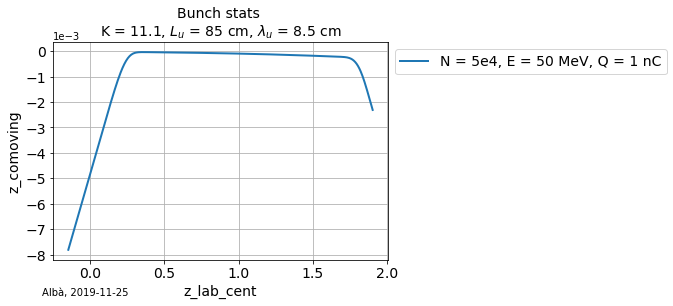

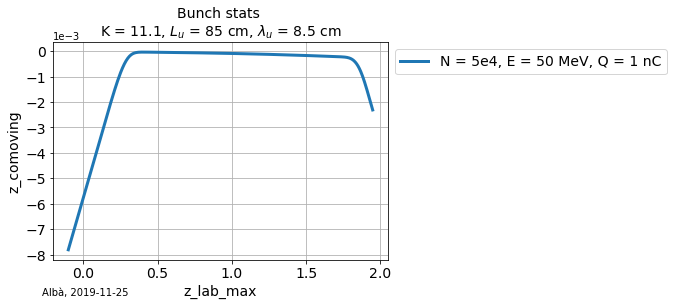

In [3]:
#plot bunch stats

title = str('Bunch stats \n' + generic_title)

# Edit here  #######################
xquant = 'z_lab_cent'
yquant = 'z_comoving'
shift = 0.0
dotted = [2]
####################################

axes = [names.index(xquant), names.index(yquant)]
for d,dat in enumerate(data_samp):
    plt.figure(1)
    x = np.array( dat.iloc[:,[axes[0]]] )
    y = np.array( dat.iloc[:,[axes[1]]] ) - d*shift
    if(d in dotted):
        m = ':'
    else:
        m = '-'
    plt.plot(x, y, linewidth = lw, linestyle = m)
    print(folders[d])
    print('x initial is ' + str(x[0]))
    print('x final is ' + str(x[-1]))
    print('y initial is ' + str(y[0]))
    print('y final is ' + str(y[-1]) + '\n' )

fig = plt.figure(1)
plt.title(title, fontsize = fs)
plt.legend(leg, fontsize = fs, bbox_to_anchor = [1., 1.])
fig.text(.2, .0, footnote, ha='center')
plt.xlabel( names[axes[0]], fontsize = fs )
plt.ylabel( names[axes[1]], fontsize = fs )
plt.ticklabel_format(style='sci', axis='x', scilimits=(-1,2))
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,2))
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.grid()
# plt.xlim(left = -0.9, right = 0)
# plt.ylim(bottom = .1, top = .15)
# plt.savefig((pltpath + '/FELstat.eps'),bbox_inches='tight')
print('\n\n')


# Edit here  #######################
xquant = 'z_lab_max'
yquant = 'z_comoving'
shift = 0.0
dotted = [2 ]
####################################

axes = [names.index(xquant), names.index(yquant)]
for d,dat in enumerate(data_samp):
    plt.figure(2)
    x = np.array( dat.iloc[:,[axes[0]]] )
    y = np.array( dat.iloc[:,[axes[1]]] ) - d*shift
    if(d in dotted):
        m = ':'
    else:
        m = '-'
    plt.plot(x, y, linewidth = lw + 1 , linestyle = m)
    print('x initial is ' + str(x[0]))
    print('x final is ' + str(x[-1]))
    print('y initial is ' + str(y[0]))
    print('y final is ' + str(y[-1]) + '\n' )

fig = plt.figure(2)
plt.title(title, fontsize = fs)
plt.legend(leg, fontsize = fs, bbox_to_anchor = [1., 1.])
fig.text(.2, .0, footnote, ha='center')
plt.xlabel( names[axes[0]], fontsize = fs )
plt.ylabel( names[axes[1]], fontsize = fs )
plt.ticklabel_format(style='sci', axis='x', scilimits=(-1,2))
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,2))
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.grid()
# plt.xlim(left = 6e-12, right = 1e-10)
# plt.ylim(bottom = -.0005, top = .0)
# plt.savefig((pltpath + '/FELstat2.eps'),bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


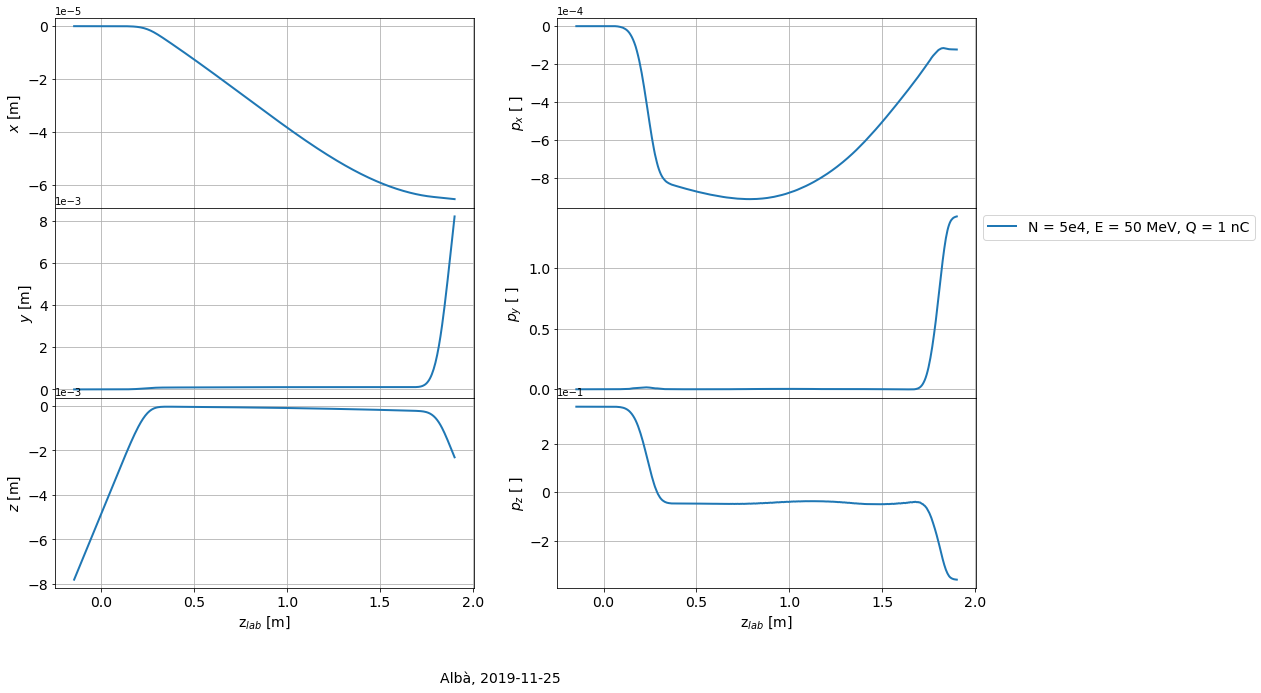

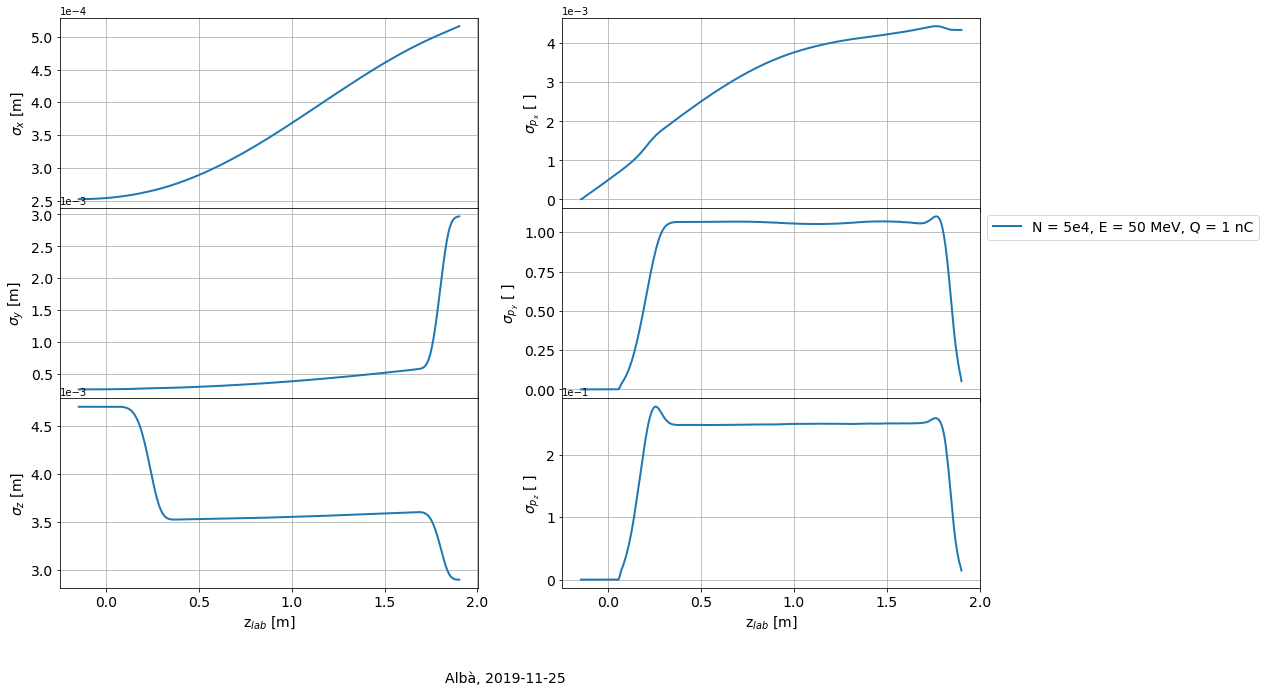

In [4]:
# At a glance
title = str('Bunch stats \n' + generic_title)
dotted = [2]

fig, ax = plt.subplots(3,2, sharex=True, gridspec_kw={'hspace': 0})
fig.set_size_inches(16.5, 10.5)
for d, dat in enumerate(data_samp):    
    if d in dotted:
        ls = ':'
        lw = 3
    else:
        ls = '-'
        lw = 2
    ax[0,0].plot(dat['z_lab_cent'], dat['x'], lw = lw, linestyle = ls)
    ax[0,0].set_ylabel('$x$ [m]', fontsize = fs)
    ax[1,0].plot(dat['z_lab_cent'], dat['y'], lw = lw, linestyle = ls)
    ax[1,0].set_ylabel('$y$ [m]', fontsize = fs)
    ax[2,0].plot(dat['z_lab_cent'], dat['z_comoving'], lw = lw, linestyle = ls)
    ax[2,0].set_ylabel('$z$ [m]', fontsize = fs)
    ax[2,0].set_xlabel('z$_{lab}$ [m]', fontsize = fs)
    
    ax[0,1].plot(dat['z_lab_cent'], dat['px'], lw = lw, linestyle = ls)
    ax[0,1].set_ylabel('$p_x$ [ ]', fontsize = fs)
    ax[1,1].plot(dat['z_lab_cent'], dat['py'], lw = lw, linestyle = ls)
    ax[1,1].set_ylabel('$p_y$ [ ]', fontsize = fs)
    ax[2,1].plot(dat['z_lab_cent'], dat['pz'], lw = lw, linestyle = ls)
    ax[2,1].set_ylabel('$p_z$ [ ]', fontsize = fs)
    ax[2,1].set_xlabel('z$_{lab}$ [m]', fontsize = fs)
    
ax[1,1].legend(leg, fontsize = fs, bbox_to_anchor = [1., 1.])

for i in ax:
    for j in i:
        j.tick_params(axis = 'both', which = 'major', labelsize = fs)
        j.ticklabel_format(style='sci', axis='both', scilimits=(-1,2))
        j.grid()
#         j.set_xlim(left = -4, right = 4)

fig.text(.5, .0, footnote, fontsize = fs, ha='center')
plt.savefig((pltpath + '/glanceAvg.eps'),bbox_inches='tight')


fig, ax = plt.subplots(3,2, sharex=True, gridspec_kw={'hspace': 0})
fig.set_size_inches(16.5, 10.5)
for d, dat in enumerate(data_samp):    
    if d in dotted:
        ls = ':'
        lw = 3
    else:
        ls = '-'
        lw = 2
    ax[0,0].plot(dat['z_lab_cent'], dat['sig_x'], lw = lw, linestyle = ls)
    ax[0,0].set_ylabel('$\sigma_{x}$ [m]', fontsize = fs)
    ax[1,0].plot(dat['z_lab_cent'], dat['sig_y'], lw = lw, linestyle = ls)
    ax[1,0].set_ylabel('$\sigma_{y}$ [m]', fontsize = fs)
    ax[2,0].plot(dat['z_lab_cent'], dat['sig_z'], lw = lw, linestyle = ls)
    ax[2,0].set_ylabel('$\sigma_{z}$ [m]', fontsize = fs)
    ax[2,0].set_xlabel('z$_{lab}$ [m]', fontsize = fs)
    
    ax[0,1].plot(dat['z_lab_cent'], dat['sig_px'], lw = lw, linestyle = ls)
    ax[0,1].set_ylabel('$\sigma_{p_x}$ [ ]', fontsize = fs)
    ax[1,1].plot(dat['z_lab_cent'], dat['sig_py'], lw = lw, linestyle = ls)
    ax[1,1].set_ylabel('$\sigma_{p_y}$ [ ]', fontsize = fs)
    ax[2,1].plot(dat['z_lab_cent'], dat['sig_pz'], lw = lw, linestyle = ls)
    ax[2,1].set_ylabel('$\sigma_{p_z}$ [ ]', fontsize = fs)
    ax[2,1].set_xlabel('z$_{lab}$ [m]', fontsize = fs)
    
ax[1,1].legend(leg, fontsize = fs, bbox_to_anchor = [1., 1.])

for i in ax:
    for j in i:
        j.tick_params(axis = 'both', which = 'major', labelsize = fs)
        j.ticklabel_format(style='sci', axis='both', scilimits=(-1,2))
        j.grid()
#         j.set_xlim(left = -4, right = 4)

fig.text(.5, .0, footnote, fontsize = fs, ha='center')
plt.savefig((pltpath + '/glanceStd.eps'),bbox_inches='tight')


plt.show()

In [6]:
data_p = []

for f in folders:
    fname = str( f + '/power-sampling/power-NSFD-0.txt')
    print(fname)
    data_p.append( pd.read_csv(fname, sep='\t', header = None, index_col = False, names = ['z', 'p']) )

# data[0]

example2/power-sampling/power-NSFD-0.txt


example2
total radiatied power =  163203.6024952416
z_rad initial is -1.1028836672643407


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


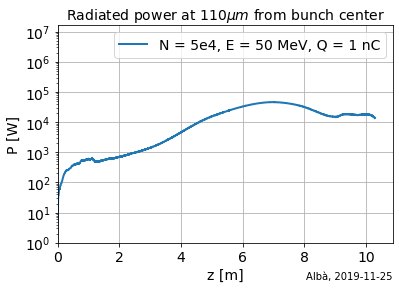

In [8]:
#plot power

# Edit here #########################
colors = ['b', 'darkorange', 'green']
dotted = [2]
#####################################

totP = []
for i,dat in enumerate(data_p):
    x = np.array(dat.z)
    y = np.array(dat.p)
    if(i in dotted):
        m = ':'
        lw = 3
    else:
        m = '-'
        lw = 2
    c = colors[i % len(colors)]
    plt.figure(1)
    plt.semilogy(x, y, lw = lw, linestyle = m)
#     plt.figure(2)
#     plt.plot(x,y, lw = 4, linestyle = m)
    tot = scipy.integrate.trapz(y=y,x=x)
#     tot = np.max(y)
    totP.append(tot)
    print(folders[i])
    print('total radiatied power = ', tot)
    print('z_rad initial is ' + str(x[0]))
    
# title = str('Radiated power at $110\mu m$ from bunch center\n' + generic_title)
title = str('Radiated power at $110\mu m$ from bunch center')
# Logarithmic plot
fig = plt.figure(1)
plt.title(title, fontsize = fs)
plt.legend(leg, fontsize = fs, bbox_to_anchor = [1., 1.])
fig.text(.8, .0, footnote, ha='center')
plt.xlabel('z [m]', fontsize = fs)
plt.ylabel('P [W]', fontsize = fs)
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.grid()
plt.xlim(left = 0)
plt.ylim(bottom = 1)
plt.savefig((pltpath + '/FELpower-log.eps'),bbox_inches='tight')

plt.show()

In [9]:
# Import bunch profile
# Edit here ####################

################################

pnames = ['q', 'x', 'y', 'z', 'px', 'py', 'pz']
ps = []
maxNumTimes = 0
for el in time_stamps:
    if len(el) > maxNumTimes:
        maxNumTimes = len(el)
        maxTimes = el

for f, name in enumerate(folders):
    fname = name + '/bunch-profile/bunch-p#-$.txt'
    post = fname.find('$')
    posp = fname.find('#')
    
    times = time_stamps[f]
    for t in range(maxNumTimes):
        data_bunch = []
        if len(time_stamps[f]) <= t:
            data_bunch.append( pd.DataFrame(data = {'q':[], 'x':[], 'y':[], 'z':[],
                                                       'px':[], 'py':[], 'pz':[]}) )
            print(t,fname,'is empty')
        else:
            tname = fname[:post] + str(times[t]) + fname[post+1:]
            print(t, tname)
            for p in range(nump[f]):
                pname = tname[:posp] + str(p) + tname[posp+1:]
                if ( os.path.isfile(pname) ):
                    data_bunch.append( pd.read_csv(pname, sep='\t',
                                               header = None, names = pnames) )
                else:
                    print(pname + ' is empty')
                    data_bunch.append( pd.DataFrame(data = {'q':[], 'x':[], 'y':[], 'z':[],
                                                           'px':[], 'py':[], 'pz':[]}) )
        ps.append( pd.concat(data_bunch) )
        
print(pnames, folders)


0 example2/bunch-profile/bunch-p#-0.txt


['q', 'x', 'y', 'z', 'px', 'py', 'pz'] ['example2']


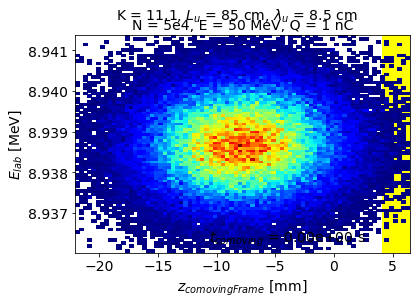

In [10]:
# plot phase-space for two folders

# Edit here ###############
f_to_plot = [ ]  # Indices of folders to plot. Leave empty to plot all
t_to_plot = [ ]  # Indices of times to plot. Leave empty to plot all
labs = [ '$z_{comovingFrame}$ [mm]', '$E_{lab}$ [MeV]' ]  # Labels
quantities = ['z', 'E']
factors = [ 1000, 1]
nbins = 80
yl = []  # plot limits
xl = []  # plot limits
type = 'hist2d'  # 'mod' for energy modulation, 'scatter' or 'hist2d'
###########################
if len(xl) == 0 or len(yl) == 0:
    xl = [None, None]
    yl = [None, None]
if len(t_to_plot) == 0:
    t_to_plot = list(range(maxNumTimes))
if len(f_to_plot) == 0:
    f_to_plot = list(range(len(folders)))
sizettp = len(t_to_plot)
sizeftp = len(f_to_plot)
fig, axs = plt.subplots( nrows = sizettp, ncols = sizeftp, sharex = False, sharey = True)
axs = np.array(axs)
# Make plots
for i, ax in enumerate(axs.reshape(-1)):
    # Get indices
    fi = i%sizeftp
    ti = int(i/sizeftp)
    t = t_to_plot[ti]
    f = f_to_plot[fi]
    if t >= maxNumTimes:
        print('index of times to plot too large')
        break
    if f >= len(folders):
        print('index of folders to plot too large')
        break
    d_to_plot = ps[ f*maxNumTimes + t ]
    # Plot undulator zone
    if quantities[0] == 'z':
        undStart = gamma_*rb[f] - time_stamps[f][t]*dt[f] / gamma_ * beta_ * C 
        undEnd = undStart + Lu/gamma_
        ax.axvspan( undStart * factors[0], undEnd * factors[0], color='yellow', zorder = 1)
    # Get energy in lab frame if necessary to plot it
    if 'E' in quantities:
        mc2 = .511  # MeV/c2 electron mass
        if 'E' not in pnames:
            pnames = [ pnames, 'E' ]
        px = np.array(d_to_plot['px'])
        py = np.array(d_to_plot['py'])
        pz = np.array(d_to_plot['pz'])
        E = []
        for i in zip( px, py, pz):
            bg = np.linalg.norm( i )
            g = np.sqrt( 1 + np.power( bg, 2. ) )
            glab = gamma_ * ( g + beta_ * i[2] )
            E.append( mc2 * glab )
        d_to_plot['E'] = E
    # Plot stuff
    x = np.array(d_to_plot[quantities[0]]) * factors[0]
    y = np.array(d_to_plot[quantities[1]]) * factors[1]
    if type == 'scatter':
        ax.scatter( x, y, marker = '.', zorder = 2)
    elif type == 'hist2d':
        ax.hist2d( x, y, bins = nbins, cmin = 1 , cmap=plt.cm.jet, zorder = 2)
    elif type == 'mod' and len(x) > 0:
        bin_edges = np.linspace( np.min(x), np.max(x), nbins )
        bin_size = bin_edges[1] - bin_edges[0]
        digitized = np.digitize( x, bin_edges )  # Get data organised in bins
        bin_means = [y[digitized == i].mean() for i in range(1, len(bin_edges))]
        bin_means -= bin_means[0]
        ax.plot( bin_edges[1:] - .5*bin_size, bin_means, zorder = 2, lw = 2)
        xl = [np.min(x), np.max(x)]
        ax.grid()
    # Get labels and limits if not given
    if len(labs) == 0:
        labs = quantities
    # Figure parameters
    ax.tick_params(labelsize = fs)
    if ti == sizettp - 1:
        ax.set_xlabel(labs[0], fontsize = fs)
    if fi == 0:
        ax.set_ylabel(labs[1], fontsize = fs)
    ax.set_xlim( left = xl[0], right = xl[1] )
    ax.set_ylim( bottom = yl[0], top = yl[1] )
    ax.text(.4,.05, ( '$t_{comoving}$ = ' + '%.2e' % Decimal(time_stamps[f][t]*dt[f]) + ' s' ), transform=ax.transAxes, fontsize = fs)
    if ti == 0:
        ax.set_title( leg[f], fontsize = fs )
    
fig.suptitle(generic_title, fontsize = fs)    
fig.set_size_inches( 6*sizeftp, 4*sizettp )

# fig.text(.2, .0, footnote, fontsize = fs, ha='center')
plt.savefig((pltpath + '/phaseSpace.eps'), bbox_inches='tight')
plt.show()

In [10]:
# Import screen data 
# Edit here ####################

################################

snames = ['q', 'x', 'y', 't', 'px', 'py', 'pz']
psScr = []
maxNumScreens = 0
for el in screens:
    if len(el) > maxNumScreens:
        maxNumScreens = len(el)
        maxScreens = el

for f, name in enumerate(folders):
    fname = name + '/bunch-screen/bunch-p#-screen$.txt'
    poss = fname.find('$')
    posp = fname.find('#')
    
    for s in range(maxNumScreens):
        data_bunch = []
        if len(screens[f]) <= s:
            data_bunch.append( pd.DataFrame(data = {'q':[], 'x':[], 'y':[], 't':[],
                                                       'px':[], 'py':[], 'pz':[]}) )
            print(s,fname,'is empty')
        else:
            sname = fname[:poss] + str(s) + fname[poss+1:]
            print(s, sname)
            for p in range(nump[f]):
                pname = sname[:posp] + str(p) + sname[posp+1:]
                if ( os.path.isfile(pname) ):
                    data_bunch.append( pd.read_csv(pname, sep='\t',
                                               header = None, names = snames) )
                else:
                    print(pname + ' is empty')
                    data_bunch.append( pd.DataFrame(data = {'q':[], 'x':[], 'y':[], 't':[],
                                                           'px':[], 'py':[], 'pz':[]}) )
        psScr.append( pd.concat(data_bunch) )
        
print(snames, folders)


0 ./bunch-screen/bunch-p#-screen0.txt
1 ./bunch-screen/bunch-p#-screen1.txt


2 ./bunch-screen/bunch-p#-screen2.txt
['q', 'x', 'y', 't', 'px', 'py', 'pz'] ['.']


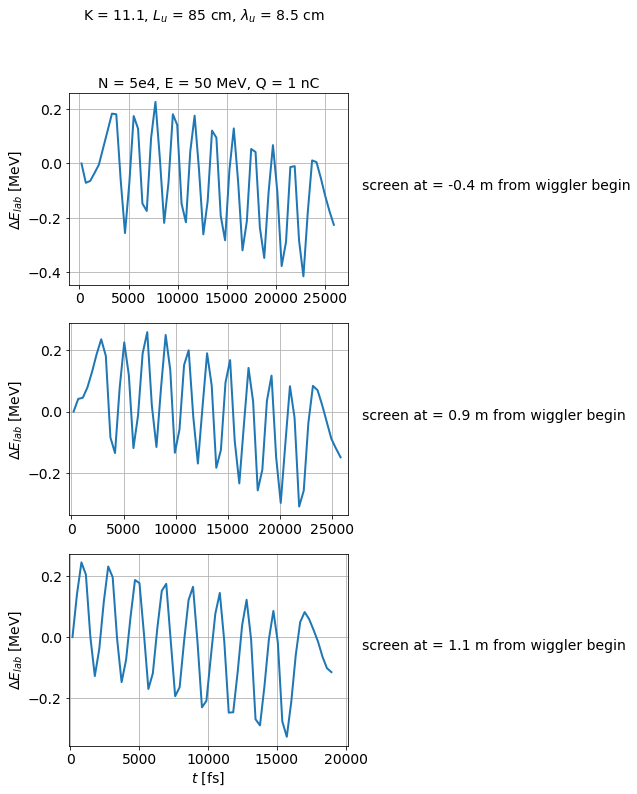

In [11]:
# plot phase-space from screen

# Edit here ###############
f_to_plot = [  ]  # Indices of folders to plot. Leave empty to plot all
s_to_plot = [  ]  # Indices of screens to plot. Leave empty to plot all
labs = [ '$t$ [fs]', '$\Delta E_{lab}$ [MeV]' ]  # Labels
factors = [ 1e15, 1]
quantities = ['t', 'E']
nbins = 60
yl = []  # plot limits
xl = []  # plot limits
type = 'mod'  # 'mod' for energy modulation, 'scatter' or 'hist2d'
###########################
if len(xl) == 0 or len(yl) == 0:
    xl = [None, None]
    yl = [None, None]
if len(s_to_plot) == 0:
    s_to_plot = list(range(maxNumScreens))
if len(f_to_plot) == 0:
    f_to_plot = list(range(len(folders)))
sizestp = len(s_to_plot)
sizeftp = len(f_to_plot)
fig, axs = plt.subplots( nrows = sizestp, ncols = sizeftp, sharex = False, sharey = False)
axs = np.array(axs)
# Make plots
for i, ax in enumerate(axs.reshape(-1)):
    # Get indices
    fi = i%sizeftp
    si = int(i/sizeftp)
    s = s_to_plot[si]
    f = f_to_plot[fi]
    if s >= maxNumScreens:
        print('index of times to plot too large')
        break
    if f >= len(folders):
        print('index of folders to plot too large')
        break
    d_to_plot = psScr[ f*maxNumScreens + s ]
    # Get energy in lab frame if necessary to plot it
    if 'E' in quantities:
        mc2 = .511  # MeV/c2 electron mass
        if 'E' not in snames:
            snames = [ snames, 'E' ]
        px = np.array(d_to_plot['px'])
        py = np.array(d_to_plot['py'])
        pz = np.array(d_to_plot['pz'])
        E = []
        for i in zip( px, py, pz):
            bg = np.linalg.norm(i)
            g = np.sqrt( 1 + np.power(bg,2.) )
            E.append( mc2*g )
        d_to_plot['E'] = E
    # Plot stuff
    x = np.array(d_to_plot[quantities[0]]) * factors[0]
    y = np.array(d_to_plot[quantities[1]]) * factors[1]
    if 't' == quantities[0]:
        x = - x
        x = x - x[0]
    if type == 'scatter':
        ax.scatter( x, y, marker = '.' )
    elif type == 'hist2d':
        ax.hist2d( x, y, bins = nbins, cmin = 1 , cmap=plt.cm.jet)
    elif type == 'mod' and len(x) > 0:
        bin_edges = np.linspace( x[0], x[-1], nbins )
        bin_size = bin_edges[1] - bin_edges[0]
        digitized = np.digitize( x, bin_edges )  # Get data organised in bins
        bin_means = [y[digitized == i].mean() for i in range(1, len(bin_edges))]
        bin_means -= bin_means[0]
        ax.plot( bin_edges[:-1] + .5*bin_size, bin_means, lw = 2)
        xl = [np.min(x), np.max(x)]
        ax.grid()
    # Get labels and limits if not given
    if len(labs) == 0:
        labs = quantities
    # Figure parameters
    if si == sizestp - 1:
        ax.set_xlabel(labs[0], fontsize = fs)
    ax.tick_params(labelsize = fs)
    if fi == 0:
        ax.set_ylabel(labs[1], fontsize = fs)
    ax.set_xlim( left = xl[0], right = xl[1] )
    ax.set_ylim( bottom = yl[0], top = yl[1] )
    if fi == sizeftp - 1:
        ax.text(1.05,.5, ( 'screen at = ' + str(maxScreens[s]) + ' m from wiggler begin' ), transform=ax.transAxes, fontsize = fs)
    if si == 0:
        ax.set_title( leg[f], fontsize = fs )
#         ax.set_title( generic_title, fontsize = fs )  # REMOVE
    

fig.suptitle( generic_title, fontsize = fs )
fig.set_size_inches( 5*sizeftp, 4*sizestp )

# fig.text(.2, .0, footnote, fontsize = fs, ha='center')
plt.savefig((pltpath + '/phaseSpaceScreen.eps'), bbox_inches='tight')
plt.show()

In [ ]:
####################################################################
####################################################################
####################################################################
####################################################################
####################################################################

In [ ]:
# OPAL MITHRA compare

# Edit here ###############
realTimes = [0, 2e-08]
folderInd1 = 1
folderInd2 = 3
labs = ['y [m]', 'z [m]']
quantities = ['y', 'z']
factors =  [ 1, 1 ]
bins = 120
yl = [-5*lamIn, 5*lamIn]
# yl = [-.012, .007]
xl = [-.0015, .0015]
type = 'hist'  # 'hist' or 'scatter' 
###########################

empty_string_labels = ['']*len(labels)
times = [0]
print(folders[folderInd1] + ', ' + folders[folderInd2])
lims = [xl, yl]
data_bunch1 = ps[ folderInd1*len(times):(folderInd1+1)*len(times) ]
bFlocal1 = bFs[ folderInd1*len(times):(folderInd1+1)*len(times) ]
data_bunch2 = ps[ folderInd2*len(times):(folderInd2+1)*len(times) ]
bFlocal2 = bFs[ folderInd2*len(times):(folderInd2+1)*len(times) ]
axes = [ pnames.index(quantities[0]), pnames.index(quantities[1]) ]
cols = data_bunch1[0].columns
fig = plt.figure()
for t, time in enumerate(times):
    # Setup subplots
    if (type == 'scatter'):
        ax1 = fig.add_axes([0, -.5*t, .5, .5], xlim = xl, ylim = yl)
        ax2 = fig.add_axes([.5, -.5*t, .5, .5], xlim = xl, ylim = yl)
        ax1.grid()
        ax2.grid()
    elif (type == 'hist'):
        ax1 = fig.add_axes([0, -.6*t, .5, .5])
        ax2 = fig.add_axes([.51, -.6*t, .5, .5])
    
    # Labels   
    ax1.set_ylabel(labs[1], fontsize =fs)
#     ax2.yaxis.tick_right()
    ax1.text(xl[0]+(xl[1]-xl[0])*2.1, yl[0]+(yl[1]-yl[0])*.5,
             ( 'Time = ' + str(realTimes[t]) + ' s' ), fontsize = fs)
    print( 'Time = ' + str(realTimes[t]) + ' s \n' 
         + folders[folderInd1]  + ' bF = ' + '%.2E' % Decimal(bFlocal1[t]) + '\n' 
         + folders[folderInd2]  + ' bF = ' + '%.2E' % Decimal(bFlocal2[t]) )
    if (t == len(times)-1):
        ax1.set_xlabel(labs[0], fontsize = fs)
        ax2.set_xlabel(labs[0], fontsize = fs)
        ax1.ticklabel_format(style='sci', axis='x', scilimits=(-1,2))
        ax2.ticklabel_format(style='sci', axis='x', scilimits=(-1,2))
#     if(t == 0):
#         ax1.xaxis.tick_top()
#         ax2.xaxis.tick_top()
            
    else:
        labels = [item.get_text() for item in ax1.get_xticklabels()]
        ax1.set_xticklabels(empty_string_labels)
        ax2.set_xticklabels(empty_string_labels)
    ax2.set_yticklabels(empty_string_labels)
    
    if (t == 0):
        ax1.text(xl[0]+(xl[1]-xl[0])*.15, yl[0]+(yl[1]-yl[0])*1.15, leg[folderInd1], fontsize = fs)
        ax2.text(xl[0]+(xl[1]-xl[0])*.15, yl[0]+(yl[1]-yl[0])*1.15, leg[folderInd2], fontsize = fs)
    
    
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1,2))
    
    # Plot
    x1 = np.array(data_bunch1[t].iloc[:,[axes[0]]])[:,0] / factors[0]
    y1 = np.array(data_bunch1[t].iloc[:,[axes[1]]])[:,0] / factors[1]
    x2 = np.array(data_bunch2[t].iloc[:,[axes[0]]])[:,0] / factors[0]
    y2 = np.array(data_bunch2[t].iloc[:,[axes[1]]])[:,0] / factors[1]
    if (type == 'scatter'):
        ax1.scatter(x1, y1, marker = '.')
        ax2.scatter(x2, y2, marker = '.')
    elif(type == 'hist'):
        ax1.hist2d(x1, y1, bins = bins, range = lims)
        ax2.hist2d(x2, y2, bins = bins, range = lims)

plt.savefig((pltpath + '/phaseSpace.eps'),bbox_inches='tight')
plt.show()

In [ ]:
def bf(z, l):
    ku = 2.0 * np.pi / l
    ts = np.average( np.sin( ku*z ) )
    tc = np.average( np.cos( ku*z ) )
    return np.sqrt(ts**2 + tc**2)

# Edit here ###########
lu = .03
lamLab = lu / gamma_ / gamma_ / 2
lamIn = lu / gamma_ / 2
lamOut = lu / gamma_ / zeta / 2
lamUse = lamIn
rho = .006
bins = int(1e3)
#######################
print('lambda lab frame = ', lamLab)
print('In comoving frame:')
print('lambda outside is ' + str(lamOut) ) 
print('lambda inside is ' + str(lamIn) )
bFs = []
ku = 2*np.pi / (lamUse) 
for n, name in enumerate(folders):
    print('\n##########################################\n##########################################\n' 
              + name)
    times = time_stamps[n]
    for t, time in enumerate(times):
        ind = n*len(times) + t
        z = np.array(ps[ind].iloc[:,[3]])
        if(len(z) == 0):
            bFs.append(0)
            continue
            
        # Plot longitudinal density
        dens, bin_edges = np.histogram(z, bins = bins)
        space = np.linspace(min(z), max(z), bins)
#         plt.plot(space, dens)
#         plt.show()
        # Do FFT
        fft = np.fft.fft(dens)
#         fft = fft[5:]
        dl = space[1] - space[0]  # min lambda 
        N = bins
        # 2pi/dl = max k
        k = np.linspace(0, 2*np.pi / dl, N)
        plt.ylabel("Amplitude")
        plt.xlabel("k [rad/m]")
        plt.grid()
        
        # Compute bunching factor
        bF = bf(z, lamUse)
        bFs.append(bF)
        print('nTime = ' + str(time) + '\n ku real = ' 
              + '%.3E' % Decimal(ku) +  ', \t bF = ' + '%.2E' % Decimal(bF) )
        # Plot
        plt.plot( [ku, ku], [-1, 1], linewidth = 3 )
        plt.plot(k[:N // 2], np.abs(fft)[:N // 2] * 1 / N)  # 1 / N is a normalization factor
        plt.xlim(left=500)
        plt.ylim(top=90)
        plt.show()
        

In [ ]:
# plot phase-space at given time
# Edit here ###############
timeInd = 0
quantities = ['y', 'z']
yl = [-.02, .02]
xl = [-.002, .002]
type = 'hist'  # 'hist' or 'scatter' 
###########################

print('nTime = ' + str(times[timeInd]) )
lims = [xl, yl]
data_bunch = ps[ timeInd::len(times) ]
bFlocal = bFs[ timeInd::len(times) ]
axes = [ names.index(quantities[0]), names.index(quantities[1]) ]
cols = data_bunch[0].columns
fig = plt.figure()
for f, folder in enumerate(folders):
    if (type == 'scatter'):
        ax1 = fig.add_axes([.5*f, 0, .5, .5], xlim = xl, ylim = yl)
        ax1.grid()
    elif (type == 'hist'):
        ax1 = fig.add_axes([.51*f, 0, .5, .5])
        
    ax1.set_xlabel(cols[axes[0]], fontsize =fs)
    ax1.text(xl[0]+(xl[1]-xl[0])*.4, yl[0]+(yl[1]-yl[0])*1.1,
             ( folder + '\nbF = ' + '%.2E' % Decimal(bFlocal[f]) ), fontsize = fs)
    
    if( (f == len(folders)-1) or (f == 0) ):
        ax1.set_ylabel(cols[axes[1]], fontsize = fs)
        if(f == len(folders)-1):
            ax1.yaxis.tick_right()
    else:
        labels = [item.get_text() for item in ax1.get_yticklabels()]
        empty_string_labels = ['']*len(labels)
        ax1.set_yticklabels(empty_string_labels)

    x = np.array(data_bunch[f].iloc[:,[axes[0]]])[:,0]
    y = np.array(data_bunch[f].iloc[:,[axes[1]]])[:,0]
    if (type == 'scatter'):
        ax1.scatter(x, y, marker = '.')
    elif(type == 'hist'):
        ax1.hist2d(x, y, bins = 100, range = lims)


plt.savefig((pltpath + '/phaseSpace.eps'),bbox_inches='tight')
plt.show()


In [ ]:
data_field = []
data_field.append( pd.read_csv('in_SI_units/field-sampling/field-14.txt',
                        sep='\t', header = None, index_col = False, 
                               names = ['t', 'x', 'y', 'z', 'Ex', 'Ey', 'Ez']) )
data_field.append( pd.read_csv('file_copy_OPAL/field-sampling/field-14.txt',
                        sep='\t', header = None, index_col = False, 
                               names = ['t', 'x', 'y', 'z', 'Ex', 'Ey', 'Ez']) )


# data_field[0]

In [ ]:
# Plot electric field


fig = plt.figure()

for i, dat in enumerate(data_field):
    x = np.array(dat.t)
    y = np.array(dat.Ey*1e-6)
    plt.plot( x, y, lw = 2, alpha= 1-i*.3 )

plt.title('Transverse electric field \n' + str(nump) + ' cores, no space-charge, E = 50 MeV, K = 1.417,\n$\lambda_u = 3$ cm, $L_u = 9$ m, n_part = 15000, Q = 29.5 pC',
         fontsize = fs)
fig.text(.8, -0.1, footnote, ha='center')
plt.xlabel('t [s]', fontsize = fs)
plt.ylabel('$E_y$ [Mv/m]', fontsize = fs)
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.legend(leg, fontsize = fs)
# plt.ylim(bottom = 1)
# plt.xlim(left=0)
plt.savefig((pltpath + '/FEL-Efield.eps'),bbox_inches='tight')
plt.show()

In [ ]:
# bF in lab frame

# Edit here ###########
lu = .03
bins = int(1e3)
#######################

# Check initial profile for OPAL

kuLab = 2*np.pi / ( lu / gamma_**2 / 2 )
for n, name in enumerate(folders):
    prof = pd.read_csv( (name + '/initial-profile-unboosted.tsv'),
                      sep = '\t', header = None, index_col = False, skiprows = 1, 
                      names = ['x', 'px', 'y', 'py', 'z', 'pz'])
    print('\n' + name)
    z = np.array(prof.iloc[:,[4]])
    zc = np.average( np.cos( kuLab*z ) )
    zs = np.average( np.sin( kuLab*z ) )
    bF = np.sqrt( zc**2 + zs**2 )
    print('bF = ' + '%.2E' % Decimal(bF) )
    
   # Plot longitudinal density
    dens, bin_edges = np.histogram(z, bins = bins)
    space = np.linspace(min(z), max(z), bins)
#     plt.plot(space, dens)
#     plt.show()

    fft = np.fft.fft(dens)

    dl = space[1] - space[0]  # min lambda 
    N = bins

    # 2pi/dl = max k
    k = np.linspace(0, 2*np.pi / dl, N)

    plt.ylabel("Amplitude")
    plt.xlabel("k [rad/m]")
    plt.grid()
    plt.plot( [kuLab, kuLab], [-1, 80], linewidth = 3 )
    plt.plot(k[:N // 2], np.abs(fft)[:N // 2] * 1 / N)  # 1 / N is a normalization factor
    plt.show()